# Construisez un modèle de scoring

### Import des librairies

In [1]:
import re
import numpy as np
import pandas as pd
import gc
#import time
#from contextlib import contextmanager
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonctions

In [2]:
# Fonction qui retourne un objet Pandas.Series avec en index les noms des variables et en values le nombre de modalités
# df : DataFrame
# liste_var_quali : tableau des varibales ou les modalités sont à dénombrer
def nb_modalite(df, liste_var_quali):
    tab_index = []
    tab_values = []
    tab_listes = []
    for i in range(len(liste_var_quali)) :
        effectifs = df[liste_var_quali[i]].value_counts(dropna= False) # On récupère la série qui contient les modalités et leurs effectifs
        tab_index.append(liste_var_quali[i])
        tab_values.append(len(effectifs.index))
        tab_listes.append(effectifs.index)
    return (pd.Series(tab_values, tab_index), pd.Series(tab_listes, tab_index))
   

In [3]:
# cette fonction crée un dictionnaire avec pour chaque type de données la liste des rubriques
# nom_fichier_csv : chaine de caractère correspondant au nom de fichier affiché
# df : DataFrame des données à décrire

def tab_types(df):
    tab_types = {}
    liste_rub = []
    bPremiereFois = False
    for i in range(0, df.shape[1]):
        if df.dtypes.values[i] in tab_types :
            liste_rub = tab_types[df.dtypes.values[i]]
            liste_rub.append(df.dtypes.index[i])
            tab_types[df.dtypes.values[i]] = liste_rub
        else :
            liste_rub = []
            liste_rub.append(df.dtypes.index[i])
            tab_types[df.dtypes.values[i]] = liste_rub
        if '_ID_' in df.dtypes.index[i]:
            if bPremiereFois == False:                
                print("")
                print("Liste des ID présents dans le csv :")
                bPremiereFois = True
            print(df.dtypes.index[i])
    print("")
    return tab_types


In [4]:
def description(liste = None, b_dataset = False):
    if liste == None :
        liste = liste_fichiers
    
    for i in range (len(liste)):
        tab_type = {}
        liste_rub_quali = []
        liste_rub_autres = []
        
        if b_dataset:
            df = liste[i]
        else :
            df = pd.read_csv(liste[i])
        
        if b_dataset:
            print("-------------------- Dataset : --------------------")
        else :
            print("-------------------- Fichier : ", liste[i], " --------------------")
        
        print("nombre de rubriques : ", df.shape[1], " - ", "nombre d'échantillons : ", df.shape[0])
        tab_type= tab_types(df)        
    
        print("Nombre de rubriques par type : ")
        for key, value in tab_type.items():
            print('                                   {} : {}'.format(key,len(value)))
            if key == 'object':
                liste_rub_quali += tab_type[key]
            else :
                liste_rub_autres += tab_type[key]
    
        print("")        
        print("Répartition des variables quantitatives en fonction du taux de données absentes.")
        ser = df[liste_rub_autres].isna().mean().sort_values()
        binnedSer = pd.cut(ser,10)
        print(binnedSer.value_counts(sort = False))
        abs_quali = df[liste_rub_quali].isna().mean().sort_values(ascending=False)
        if len(abs_quali) > 0 :
            digits = max(len(str(max(abs_quali.values))),len(max(abs_quali.index)))
        else :
            digits = 1
        bPremiereFois = False
        for i in range (0, len(abs_quali.index)):
            if abs_quali.values[i] > 0 :                
                if bPremiereFois == False :
                    print("")
                    print("Données absentes dans les variables qualitatives :")
                    bPremiereFois = True                
                print('{0:>{numLength}}  :  {1:<{numLength}%}'.format(abs_quali.index[i], abs_quali.values[i], numLength=digits))
        if len(liste_rub_quali) > 0:
            print("")
            print("Répartition des variables qualitatives en fonction du nombre de modalités.")
            s, s1 = nb_modalite(df, liste_rub_quali)
            mod_cut = pd.cut(s,10)
            print(mod_cut.value_counts(sort = False))
            print("")
            print("Liste des modalités par variable.")
            print(s1)
            print("")
        print("")
        return df

In [5]:
def agg_categorie(df, id_pour_grouper, nom_fichier):
      
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[id_pour_grouper] = df[id_pour_grouper]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(id_pour_grouper).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (nom_fichier, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [6]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'object'):
    
        # Count the categorical columns
        df_counts = agg_categorie(df, id_pour_grouper = group_vars[0], nom_fichier = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [7]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes(exclude='object').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [8]:
def verif_nb_jours(df):
    for var in df:
        if 'DAYS' in var:
            print(var, " ", 'min : ', df[var].min(), " ", 'max : ', df[var].max())

# Création du dataset et description des données

Les données sont réparties dans 10 fichiers.<br/>
HomeCredit_columns_description.csv contient la description des colonnes.<br/>
sample_submission.csv est un exemple du résultat voulu lors du concours Kaggle.<br/>

L'objectif est d'utiliser  l'intégralité des données fournies.<br>
On part du fichier application_train.

In [9]:
application_data = description(['../input/application_train.csv'])

-------------------- Fichier :  ../input/application_train.csv  --------------------
nombre de rubriques :  122  -  nombre d'échantillons :  307511

Liste des ID présents dans le csv :
SK_ID_CURR
DAYS_ID_PUBLISH

Nombre de rubriques par type : 
                                   int64 : 41
                                   object : 16
                                   float64 : 65

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.000699, 0.0699]    54
(0.0699, 0.14]          6
(0.14, 0.21]            1
(0.21, 0.279]           0
(0.279, 0.349]          0
(0.349, 0.419]          0
(0.419, 0.489]          4
(0.489, 0.559]         18
(0.559, 0.629]          7
(0.629, 0.699]         16
dtype: int64

Données absentes dans les variables qualitatives :
        FONDKAPREMONT_MODE  :  68.386172%                
        WALLSMATERIAL_MODE  :  50.840783%                
            HOUSETYPE_MODE  :  50.176091%                
       EMERGENCYSTATE_MODE  :  47

On encode les données descriptives en données numériques.<br/>
On supprime la variable DAYS_ID_PUBLISH.<br/>

In [10]:
application_data.shape

(307511, 122)

In [11]:
# Encodage numérique des variables qualitatives
application_data_cat = pd.get_dummies(application_data.select_dtypes('object'))
application_data_cat['SK_ID_CURR'] = application_data['SK_ID_CURR']

In [12]:
application_data.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [13]:
application_data = application_data.drop(columns=application_data.select_dtypes('object').columns).merge(application_data_cat, on = 'SK_ID_CURR', how = 'left')

In [14]:
description([application_data], True)

-------------------- Dataset : --------------------
nombre de rubriques :  246  -  nombre d'échantillons :  307511

Liste des ID présents dans le csv :
SK_ID_CURR
DAYS_ID_PUBLISH

Nombre de rubriques par type : 
                                   int64 : 41
                                   float64 : 65
                                   uint8 : 140

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.000699, 0.0699]    194
(0.0699, 0.14]           6
(0.14, 0.21]             1
(0.21, 0.279]            0
(0.279, 0.349]           0
(0.349, 0.419]           0
(0.419, 0.489]           4
(0.489, 0.559]          18
(0.559, 0.629]           7
(0.629, 0.699]          16
dtype: int64



,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,0,0,0,0,0,0,1,0,1,0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,0,0,0,0,0,0,1,0,1,0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,0,0,0,0,0,1,0,0,1,0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,0,0,0,0,0,0,1,0,1,0


In [15]:
# On vérifie le nombre de jours mini et maxi de chaque variable concernée afin de remplacer les valeurs abérantes.
verif_nb_jours(application_data)

DAYS_BIRTH   min :  -25229   max :  -7489
DAYS_EMPLOYED   min :  -17912   max :  365243
DAYS_REGISTRATION   min :  -24672.0   max :  0.0
DAYS_ID_PUBLISH   min :  -7197   max :  0
DAYS_LAST_PHONE_CHANGE   min :  -4292.0   max :  0.0


In [16]:
# On remplace les valeurs abérantes.
application_data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [17]:
# On sauvegarde le fichier partiel
application_data.to_csv(r'home_credit_partiel.csv', index = False)

## Traitement du fichier bureau.csv

On va le merger avec le fichier /input/bureau.csv</br>
Ce fichier contient 1 ligne par prêt fait par le client et est lié au fichier application_train par SK_ID_CURR.<br/>
Le fichier contient des variables qualitatives et quantitatives.<br/>
Pour pouvoir fusionner les données des 2 fichiers il faut transformer les données du fichier bureau afin d'obtenir une ligne par client comme dans le fichier application_train.<br/>
On utilisera les aggrégats statistiques pour les variables quantitatives et des encodages numériques pour les variables qualitatives.<br/>

In [18]:
bureau = description(['../input/bureau.csv'])

-------------------- Fichier :  ../input/bureau.csv  --------------------
nombre de rubriques :  17  -  nombre d'échantillons :  1716428

Liste des ID présents dans le csv :
SK_ID_CURR
SK_ID_BUREAU

Nombre de rubriques par type : 
                                   int64 : 6
                                   object : 3
                                   float64 : 8

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.000715, 0.0715]    9
(0.0715, 0.143]        0
(0.143, 0.214]         1
(0.214, 0.286]         0
(0.286, 0.357]         1
(0.357, 0.429]         1
(0.429, 0.5]           0
(0.5, 0.572]           0
(0.572, 0.643]         0
(0.643, 0.715]         2
dtype: int64

Répartition des variables qualitatives en fonction du nombre de modalités.
(3.989, 5.1]    2
(5.1, 6.2]      0
(6.2, 7.3]      0
(7.3, 8.4]      0
(8.4, 9.5]      0
(9.5, 10.6]     0
(10.6, 11.7]    0
(11.7, 12.8]    0
(12.8, 13.9]    0
(13.9, 15.0]    1
dtype: int64

Liste des modali

In [19]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [20]:
verif_nb_jours(bureau)

DAYS_CREDIT   min :  -2922   max :  0
DAYS_CREDIT_ENDDATE   min :  -42060.0   max :  31199.0
DAYS_ENDDATE_FACT   min :  -42023.0   max :  0.0
DAYS_CREDIT_UPDATE   min :  -41947   max :  372


In [21]:
# Création de l'aggrégat statistique sur le nombre de lignes, moyenne, max et min
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

In [22]:
# on renomme les colonnes
columns = ['SK_ID_CURR']
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [23]:
# on merge avec les data du fichier application_train
application_data = application_data.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
del bureau_agg
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [24]:
# Encodage numérique des variables qualitatives
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

In [25]:
# On aggrege les données de manière à avoir une seule ligne par ID
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [26]:
# On renomme les colonnes
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != 'SK_ID_CURR':
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [27]:
# on merge avec les data du fichier application_test
application_data = application_data.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
del categorical
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Traitement du fichier bureau_balance

In [28]:
bureau_balance = description(['../input/bureau_balance.csv'])

-------------------- Fichier :  ../input/bureau_balance.csv  --------------------
nombre de rubriques :  3  -  nombre d'échantillons :  27299925

Liste des ID présents dans le csv :
SK_ID_BUREAU

Nombre de rubriques par type : 
                                   int64 : 2
                                   object : 1

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.001, -0.0008]     0
(-0.0008, -0.0006]    0
(-0.0006, -0.0004]    0
(-0.0004, -0.0002]    0
(-0.0002, 0.0]        2
(0.0, 0.0002]         0
(0.0002, 0.0004]      0
(0.0004, 0.0006]      0
(0.0006, 0.0008]      0
(0.0008, 0.001]       0
dtype: int64

Répartition des variables qualitatives en fonction du nombre de modalités.
(7.992, 7.994]    0
(7.994, 7.995]    0
(7.995, 7.997]    0
(7.997, 7.998]    0
(7.998, 8.0]      1
(8.0, 8.002]      0
(8.002, 8.003]    0
(8.003, 8.005]    0
(8.005, 8.006]    0
(8.006, 8.008]    0
dtype: int64

Liste des modalités par variable.
STATUS    Index(['C', 

In [29]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [30]:
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [31]:
verif_nb_jours(bureau_balance)

In [32]:
# Encodage numérique des variables qualitatives
categ_status = pd.get_dummies(bureau_balance.select_dtypes('object'))
categ_status['SK_ID_BUREAU'] = bureau_balance['SK_ID_BUREAU']

In [33]:
# On aggrege les données de manière à avoir une seule ligne par ID
bureau_balance_counts = categ_status.groupby('SK_ID_BUREAU').agg(['sum', 'mean'])
bureau_balance_counts.head()

STATUS_0           STATUS_1      STATUS_2      STATUS_3       \
                  sum      mean      sum mean      sum mean      sum mean   
SK_ID_BUREAU                                                                
5001709             0  0.000000        0  0.0        0  0.0        0  0.0   
5001710             5  0.060241        0  0.0        0  0.0        0  0.0   
5001711             3  0.750000        0  0.0        0  0.0        0  0.0   
5001712            10  0.526316        0  0.0        0  0.0        0  0.0   
5001713             0  0.000000        0  0.0        0  0.0        0  0.0   

             STATUS_4      STATUS_5      STATUS_C           STATUS_X            
                  sum mean      sum mean      sum      mean      sum      mean  
SK_ID_BUREAU                                                                    
5001709             0  0.0        0  0.0       86  0.886598       11  0.113402  
5001710             0  0.0        0  0.0       48  0.578313       30  0.361446  
5001711             0  0.0        0  0.0        0  0.000000        1  0.250000  
5001712             0  0.0        0  0.0        9  0.473684        0  0.000000  
5001713             0  0.0        0  0.0        0  0.000000       22  1.000000

In [34]:
# On renomme les colonnes
columns = []

# Iterate through the variables names
for var in bureau_balance_counts.columns.levels[0]:
    # Skip the grouping variable
    if var != 'SK_ID_CURR':
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('bureau_balance_%s_%s' % (var, stat))

#  Rename the columns
bureau_balance_counts.columns = columns

bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [35]:
# Création de l'aggrégat statistique sur le nombre de lignes, moyenne, max et min
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_balance_agg.head()

SK_ID_BUREAU MONTHS_BALANCE                    
                        count  mean max min   sum
0      5001709             97 -48.0   0 -96 -4656
1      5001710             83 -41.0   0 -82 -3403
2      5001711              4  -1.5   0  -3    -6
3      5001712             19  -9.0   0 -18  -171
4      5001713             22 -10.5   0 -21  -231

In [36]:
# on renomme les colonnes
columns = ['SK_ID_BUREAU']
for var in bureau_balance_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_BUREAU':
        
        # Iterate through the stat names
        for stat in bureau_balance_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_balance_%s_%s' % (var, stat))
bureau_balance_agg.columns = columns
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [37]:
# On merge bureau et bureau_balance
bureau_by_loan = bureau_balance_agg.merge(categorical_grouped, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

In [38]:
# On remet la clef SK_ID_CURR dans le dataframe
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
del categorical_grouped
del bureau
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,...,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm,SK_ID_CURR
0,5001709,97.0,-48.0,0.0,-96.0,-4656.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001710,83.0,-41.0,0.0,-82.0,-3403.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162368.0
2,5001711,4.0,-1.5,0.0,-3.0,-6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162368.0
3,5001712,19.0,-9.0,0.0,-18.0,-171.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162368.0
4,5001713,22.0,-10.5,0.0,-21.0,-231.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150635.0


In [39]:
bureau_balance_by_client = bureau_by_loan.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()


In [40]:
# on renomme les colonnes
columns = ['SK_ID_CURR']
for var in bureau_balance_by_client.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_balance_by_client.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('client_%s_%s' % (var, stat))
bureau_balance_by_client.columns = columns
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_CREDIT_TYPE_Unknown type of loan_count_count,client_CREDIT_TYPE_Unknown type of loan_count_mean,client_CREDIT_TYPE_Unknown type of loan_count_max,client_CREDIT_TYPE_Unknown type of loan_count_min,client_CREDIT_TYPE_Unknown type of loan_count_sum,client_CREDIT_TYPE_Unknown type of loan_count_norm_count,client_CREDIT_TYPE_Unknown type of loan_count_norm_mean,client_CREDIT_TYPE_Unknown type of loan_count_norm_max,client_CREDIT_TYPE_Unknown type of loan_count_norm_min,client_CREDIT_TYPE_Unknown type of loan_count_norm_sum
0,100001.0,7,24.571429,52.0,2.0,172.0,7,-11.785714,-0.5,-25.5,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
1,100002.0,8,13.750000,22.0,4.0,110.0,8,-21.875000,-1.5,-39.5,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
2,100005.0,3,7.000000,13.0,3.0,21.0,3,-3.000000,-1.0,-6.0,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
3,100010.0,2,36.000000,36.0,36.0,72.0,2,-46.000000,-19.5,-72.5,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
4,100013.0,4,57.500000,69.0,40.0,230.0,4,-28.250000,-19.5,-34.0,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0


In [41]:
# on merge avec les data du fichier application_data
application_data = application_data.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
del bureau_balance
del categ_status
del bureau_balance_counts
del bureau_balance_agg
del bureau_by_loan
del bureau_balance_by_client
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_CREDIT_TYPE_Unknown type of loan_count_count,client_CREDIT_TYPE_Unknown type of loan_count_mean,client_CREDIT_TYPE_Unknown type of loan_count_max,client_CREDIT_TYPE_Unknown type of loan_count_min,client_CREDIT_TYPE_Unknown type of loan_count_sum,client_CREDIT_TYPE_Unknown type of loan_count_norm_count,client_CREDIT_TYPE_Unknown type of loan_count_norm_mean,client_CREDIT_TYPE_Unknown type of loan_count_norm_max,client_CREDIT_TYPE_Unknown type of loan_count_norm_min,client_CREDIT_TYPE_Unknown type of loan_count_norm_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## fichier previous_application

In [42]:
previous_application = description(['../input/previous_application.csv'])

-------------------- Fichier :  ../input/previous_application.csv  --------------------
nombre de rubriques :  37  -  nombre d'échantillons :  1670214

Liste des ID présents dans le csv :
SK_ID_PREV
SK_ID_CURR

Nombre de rubriques par type : 
                                   int64 : 6
                                   object : 16
                                   float64 : 15

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.000996, 0.0996]    8
(0.0996, 0.199]        0
(0.199, 0.299]         3
(0.299, 0.399]         0
(0.399, 0.498]         6
(0.498, 0.598]         2
(0.598, 0.698]         0
(0.698, 0.797]         0
(0.797, 0.897]         0
(0.897, 0.996]         2
dtype: int64

Données absentes dans les variables qualitatives :
           NAME_TYPE_SUITE  :  49.119754%                
       PRODUCT_COMBINATION  :  0.020716%                 

Répartition des variables qualitatives en fonction du nombre de modalités.
(1.974, 4.6]    6
(4.6, 7.2]

In [43]:
previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [44]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
verif_nb_jours(previous_application)

DAYS_DECISION   min :  -2922   max :  -1
DAYS_FIRST_DRAWING   min :  -2922.0   max :  365243.0
DAYS_FIRST_DUE   min :  -2892.0   max :  365243.0
DAYS_LAST_DUE_1ST_VERSION   min :  -2801.0   max :  365243.0
DAYS_LAST_DUE   min :  -2889.0   max :  365243.0
DAYS_TERMINATION   min :  -2874.0   max :  365243.0


In [46]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [47]:
# calcul des agrégats statistiques
previous_application_agg = previous_application.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

# on renomme les colonnes
columns = ['SK_ID_CURR']
for var in previous_application_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in previous_application_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('%s_%s_%s' % ('previous_application',var, stat))
previous_application_agg.columns = columns
previous_application_agg.head()

,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,...,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [48]:
# on agrège les données qualitatives
previous_counts = agg_categorie(previous_application, 'SK_ID_CURR', 'previous')
previous_counts.head()

,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [49]:
# on merge avec le fichier principal
application_data.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
del previous_application
del previous_counts

## fichier POS_CASH_balance

In [50]:
POS_CASH_balance = description(['../input/POS_CASH_balance.csv'])

-------------------- Fichier :  ../input/POS_CASH_balance.csv  --------------------
nombre de rubriques :  8  -  nombre d'échantillons :  10001358

Liste des ID présents dans le csv :
SK_ID_PREV
SK_ID_CURR

Nombre de rubriques par type : 
                                   int64 : 5
                                   float64 : 2
                                   object : 1

Répartition des variables quantitatives en fonction du taux de données absentes.
(-2.61e-06, 0.000261]    5
(0.000261, 0.000522]     0
(0.000522, 0.000783]     0
(0.000783, 0.00104]      0
(0.00104, 0.0013]        0
(0.0013, 0.00157]        0
(0.00157, 0.00183]       0
(0.00183, 0.00209]       0
(0.00209, 0.00235]       0
(0.00235, 0.00261]       2
dtype: int64

Répartition des variables qualitatives en fonction du nombre de modalités.
(8.991, 8.993]    0
(8.993, 8.995]    0
(8.995, 8.996]    0
(8.996, 8.998]    0
(8.998, 9.0]      1
(9.0, 9.002]      0
(9.002, 9.004]    0
(9.004, 9.005]    0
(9.005, 9.007]    0
(9

In [51]:
verif_nb_jours(POS_CASH_balance)

In [52]:
cash_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32.0,36.0,36.0,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361.0,456.0,456.0,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256.0,248.0,283.0,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12.0,12.0,15.0,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99.0,99.0,128.7,132.0,110,110,121,792.0,1287.0


In [53]:
application_data = application_data.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
del POS_CASH_balance
del cash_by_client
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,456.0,361.0,456.0,456.0,456.0,361.0,361.0,361.0,5415.0,8664.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,288.0,256.0,248.0,283.0,288.0,272.0,272.0,272.0,1608.0,2840.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,16.0,12.0,12.0,15.0,16.0,16.0,16.0,16.0,36.0,60.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,360.0,154.0,163.0,250.0,360.0,165.0,165.0,173.0,1294.0,1910.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,1024.0,849.0,1006.0,1012.0,1024.0,906.0,906.0,906.0,8104.0,14128.0


## fichier credit_card_balance

In [54]:
credit = description(['../input/credit_card_balance.csv'])

-------------------- Fichier :  ../input/credit_card_balance.csv  --------------------
nombre de rubriques :  23  -  nombre d'échantillons :  3840312

Liste des ID présents dans le csv :
SK_ID_PREV
SK_ID_CURR

Nombre de rubriques par type : 
                                   int64 : 7
                                   float64 : 15
                                   object : 1

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.0002, 0.02]    13
(0.02, 0.04]        0
(0.04, 0.06]        0
(0.06, 0.08]        2
(0.08, 0.1]         0
(0.1, 0.12]         0
(0.12, 0.14]        0
(0.14, 0.16]        0
(0.16, 0.18]        0
(0.18, 0.2]         7
dtype: int64

Répartition des variables qualitatives en fonction du nombre de modalités.
(6.993, 6.994]    0
(6.994, 6.996]    0
(6.996, 6.997]    0
(6.997, 6.999]    0
(6.999, 7.0]      1
(7.0, 7.001]      0
(7.001, 7.003]    0
(7.003, 7.004]    0
(7.004, 7.006]    0
(7.006, 7.007]    0
dtype: int64

Liste des moda

In [55]:
verif_nb_jours(credit)

In [56]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432432,4843.064189,4843.064189,4843.064189,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346250,7168.346250,7168.346250,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
application_data = application_data.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
del credit
del credit_by_client
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
installments = description(['../input/installments_payments.csv'])

-------------------- Fichier :  ../input/installments_payments.csv  --------------------
nombre de rubriques :  8  -  nombre d'échantillons :  13605401

Liste des ID présents dans le csv :
SK_ID_PREV
SK_ID_CURR

Nombre de rubriques par type : 
                                   int64 : 3
                                   float64 : 5

Répartition des variables quantitatives en fonction du taux de données absentes.
(-2.14e-07, 2.14e-05]    6
(2.14e-05, 4.27e-05]     0
(4.27e-05, 6.41e-05]     0
(6.41e-05, 8.54e-05]     0
(8.54e-05, 0.000107]     0
(0.000107, 0.000128]     0
(0.000128, 0.000149]     0
(0.000149, 0.000171]     0
(0.000171, 0.000192]     0
(0.000192, 0.000214]     2
dtype: int64



In [59]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,81537.750,81537.750,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1008781.155,1008781.155,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4394101.230,4394101.230,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,158906.205,158906.205,5.054566e+05,5.054566e+05


In [60]:
application_data = application_data.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
del installments
del installments_by_client
application_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1008781.155,1008781.155,4.172888e+06,4.172888e+06
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4394101.230,4394101.230,1.134881e+07,1.134881e+07
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386540e+04,6.386540e+04
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,994476.690,994476.690,691786.890,691786.890,1007153.415,1007153.415,1057860.315,1057860.315,3.719996e+06,3.719996e+06
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,483756.390,825845.850,280199.700,294631.110,806127.975,835985.340,836703.405,836703.405,1.139621e+07,1.179154e+07


In [61]:
application_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,252137.000000,...,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05,2.916430e+05
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,-2384.169325,...,2.867948e+05,4.040328e+05,3.995838e+05,3.882193e+05,6.786865e+05,6.724159e+05,3.061021e+06,3.100218e+06,1.517517e+07,1.540802e+07
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,2338.360162,...,3.944197e+05,5.197125e+05,5.142817e+05,4.684538e+05,9.162773e+05,8.800911e+05,6.551933e+06,6.607573e+06,3.392876e+07,3.439291e+07
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,...,6.173305e+04,9.587241e+04,9.684225e+04,9.970972e+04,1.308395e+05,1.346728e+05,1.826104e+05,1.838517e+05,1.132009e+06,1.160750e+06
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,...,1.508296e+05,2.160097e+05,1.931552e+05,1.995731e+05,3.186692e+05,3.283722e+05,5.457494e+05,5.526772e+05,3.539287e+06,3.662790e+06
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,...,3.450571e+05,4.948028e+05,4.939762e+05,4.983746e+05,8.331451e+05,8.432570e+05,2.367600e+06,2.416336e+06,1.401902e+07,1.426076e+07
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,...,6.829794e+06,8.280314e+06,1.934759e+07,1.934759e+07,2.553705e+07,2.327473e+07,2.351041e+08,2.351041e+08,3.908885e+09,3.923054e+09


In [62]:
_ = description([application_data], True)

-------------------- Dataset : --------------------
nombre de rubriques :  1251  -  nombre d'échantillons :  307511

Liste des ID présents dans le csv :
SK_ID_CURR
DAYS_ID_PUBLISH

Nombre de rubriques par type : 
                                   int64 : 40
                                   float64 : 1071
                                   uint8 : 140

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.001, 0.1]    461
(0.1, 0.2]       102
(0.2, 0.3]         6
(0.3, 0.4]         0
(0.4, 0.5]        10
(0.5, 0.6]        22
(0.6, 0.7]        16
(0.7, 0.8]       433
(0.8, 0.9]        63
(0.9, 1.0]       138
dtype: int64



In [63]:
# On remplace toutes les valeurs absentes par 0
application_data = application_data.fillna(0)

In [64]:
for var in application_data:
    print(application_data[var].min, )

<bound method NDFrame._add_numeric_operations.<locals>.min of 0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
307506    456251
307507    456252
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 307511, dtype: int64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    0
307510    0
Name: CNT_CHILDREN, Length: 307511, dtype: int64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         202500.0
1         270000.0
2          67500.0
3         135000.0
4         121500.0
            ...   
307506    157500.0
307507     72000.0
307508 

<bound method NDFrame._add_numeric_operations.<locals>.min of 0          1681.029
1             0.000
2             0.000
3             0.000
4             0.000
            ...    
307506        0.000
307507        0.000
307508        0.000
307509        0.000
307510    12056.481
Name: bureau_AMT_CREDIT_MAX_OVERDUE_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0          5043.645
1             0.000
2             0.000
3             0.000
4             0.000
            ...    
307506        0.000
307507        0.000
307508        0.000
307509        0.000
307510    25578.000
Name: bureau_AMT_CREDIT_MAX_OVERDUE_max, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: bureau_AMT_CREDIT_MAX_OVERDUE_min, Length: 307511, dtype: float64>


Name: client_cash_SK_DPD_mean_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         1.000000
1         0.928571
2         0.750000
3         0.857143
4         0.939394
            ...   
307506    0.777778
307507    0.857143
307508    0.882353
307509    1.000000
307510    0.915493
Name: client_cash_NAME_CONTRACT_STATUS_Active_mean_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         1.000000
1         1.000000
2         0.750000
3         1.000000
4         1.000000
            ...   
307506    0.777778
307507    0.857143
307508    1.000000
307509    1.000000
307510    0.960000
Name: client_cash_NAME_CONTRACT_STATUS_Active_mean_max, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         1.0
3         0.0
4         0.0
         ... 
307506    1.0
307507    1.0
307508    0.0
307509    0.0
307510    1

Name: client_credit_SK_DPD_mean_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_SK_DPD_mean_max, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_SK_DPD_DEF_max_min, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_SK_DPD_DEF_max_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0     

Name: client_credit_AMT_TOTAL_RECEIVABLE_sum_mean, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_AMT_RECIVABLE_sum_min, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_AMT_RECIVABLE_sum_max, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: client_credit_AMT_TOTAL_RECEIVABLE_sum_min, Length: 307511, dtype: float64>
<bound method NDFrame._add_numeric_op

In [65]:
_ =description([application_data], True)

-------------------- Dataset : --------------------
nombre de rubriques :  1251  -  nombre d'échantillons :  307511

Liste des ID présents dans le csv :
SK_ID_CURR
DAYS_ID_PUBLISH

Nombre de rubriques par type : 
                                   int64 : 40
                                   float64 : 1071
                                   uint8 : 140

Répartition des variables quantitatives en fonction du taux de données absentes.
(-0.001, -0.0008]        0
(-0.0008, -0.0006]       0
(-0.0006, -0.0004]       0
(-0.0004, -0.0002]       0
(-0.0002, 0.0]        1251
(0.0, 0.0002]            0
(0.0002, 0.0004]         0
(0.0004, 0.0006]         0
(0.0006, 0.0008]         0
(0.0008, 0.001]          0
dtype: int64



In [66]:
verif_nb_jours(application_data)

DAYS_BIRTH   min :  -25229   max :  -7489
DAYS_EMPLOYED   min :  -17912.0   max :  0.0
DAYS_REGISTRATION   min :  -24672.0   max :  0.0
DAYS_ID_PUBLISH   min :  -7197   max :  0
DAYS_LAST_PHONE_CHANGE   min :  -4292.0   max :  0.0
bureau_DAYS_CREDIT_count   min :  0.0   max :  116.0
bureau_DAYS_CREDIT_mean   min :  -2922.0   max :  0.0
bureau_DAYS_CREDIT_max   min :  -2922.0   max :  0.0
bureau_DAYS_CREDIT_min   min :  -2922.0   max :  0.0
bureau_DAYS_CREDIT_sum   min :  -80050.0   max :  0.0
bureau_DAYS_CREDIT_ENDDATE_count   min :  0.0   max :  107.0
bureau_DAYS_CREDIT_ENDDATE_mean   min :  -41875.0   max :  31198.0
bureau_DAYS_CREDIT_ENDDATE_max   min :  -41875.0   max :  31199.0
bureau_DAYS_CREDIT_ENDDATE_min   min :  -42060.0   max :  31198.0
bureau_DAYS_CREDIT_ENDDATE_sum   min :  -155271.0   max :  214193.0
bureau_DAYS_ENDDATE_FACT_count   min :  0.0   max :  108.0
bureau_DAYS_ENDDATE_FACT_mean   min :  -8376.5   max :  0.0
bureau_DAYS_ENDDATE_FACT_max   min :  -2887.0   max :  

In [3]:
# Sauvegarde sous forme de csv des données
application_data.to_csv(r'home_credit_final.csv', index = False)
del application_data

NameError: name 'application_data' is not defined

# ENTRAINEMENT DES MODELES

In [ ]:
application_data_1 = pd.read_csv('home_credit_final.csv', nrows=100000)
#application_data_1 = pd.read_csv('home_credit_final.csv')
application_data_1 = application_data_1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [3]:
# Le nombre de clients n'ayant pas remboursés leur crédit est très faible par rapport aux clients l'ayant remboursé.
print('Enregistrements avec Target à 0 : ', sum(map(lambda x: x!=1, application_data_1['TARGET'])))
print('Enregistrements avec Target à 1 : ', sum(map(lambda x: x==1, application_data_1['TARGET'])))
print('Nombre total d\'enregistrements : ', application_data_1.shape[0])

Enregistrements avec Target à 0 :  91907
Enregistrements avec Target à 1 :  8093
Nombre total d'enregistrements :  100000


In [4]:
def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 14
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 15
  plt.rcParams["ytick.labelsize"]  = 15 

C:\Users\julie\anaconda3\envs\Projet4\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


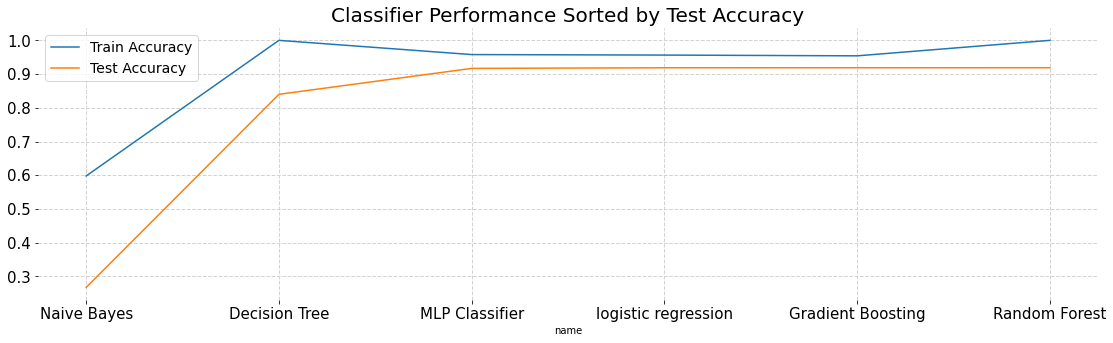

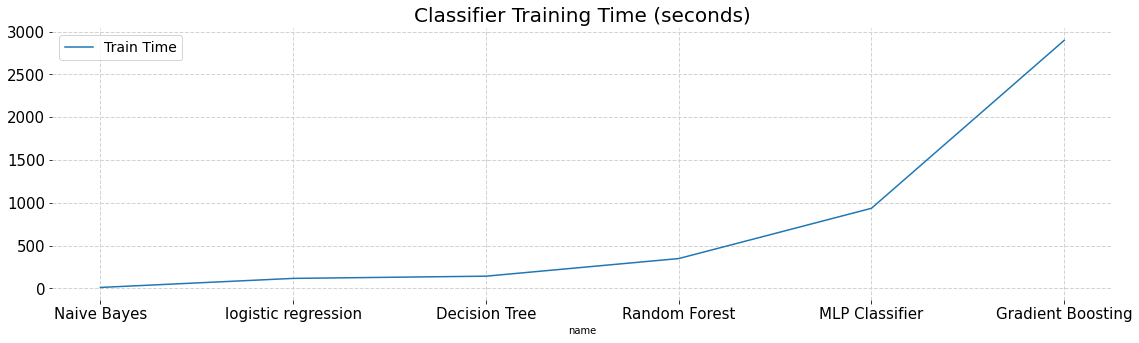

In [5]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

trained_models = [] #  keep track of all details for models we train
def train_model(model, data): 
    # On coupe notre jeu de données en 2
    train, test = train_test_split(data, test_size = 0.3, stratify=application_data_1.TARGET, random_state=42)
    # ON rééquilibre les classes avec la bibliotheque SMOTE
    from imblearn.over_sampling import SMOTE
    train_target = train['TARGET']
    train_sans_target = train.drop(columns=['TARGET'])
    X_resampled, y_resampled = SMOTE().fit_resample(train_sans_target, train_target)

    X_train= X_resampled
    X_test = test.drop(columns=['TARGET'])
    y_train= y_resampled
    y_test = test['TARGET']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

models = [
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "logistic regression", "clf": LogisticRegression(max_iter=500)}, 
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
    model_details = train_model(model, application_data_1) 
    trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False) 

# Entrainement d'un modèle supervisé classique

## Modèle linéaire : Logistic Regression

Notre cible est le remboursement ou pas du crédit. Les valeurs sont portées par la variable target du fichier application_train.csv.

In [4]:
# On scinde notre fichier en 2 pour entrainer puis valider notre modèle.
from sklearn.model_selection import train_test_split

train, test = train_test_split(application_data_1, test_size = 0.3, stratify=application_data_1.TARGET)

In [5]:
# ON rééquilibre les classes avec la bibliotheque SMOTE
from imblearn.over_sampling import SMOTE
train_target = train['TARGET']
train_sans_target = train.drop(columns=['TARGET'])
X_resampled, y_resampled = SMOTE().fit_resample(train_sans_target, train_target)


In [6]:
X_train = X_resampled
y_train = y_resampled
X_test = test.drop(columns=['TARGET'])
y_test = test['TARGET']

In [7]:
# Entrainement d'un modèle naif pour comparaison aux modèles plus évolués

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="constant", constant = 1)
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.08093333333333333

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score,recall_score,precision_score,f1_score
# On récupère la prédiction de la valeur positive
y_prob_dumies = dummy_clf.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred_dumies = np.where(y_prob_dumies > 0.5, 1, 0) 

false_positive_rate_dumies, true_positive_rate_dumies, thresholds = roc_curve(y_test, y_pred_dumies)
accuracy_score_dumies = accuracy_score(y_test, y_pred_dumies)
recall_score_dumies = recall_score(y_test, y_pred_dumies)
roc_auc_dumies = auc(false_positive_rate_dumies, true_positive_rate_dumies)
print('accuracy : ', accuracy_score_dumies)
print('auc : ', roc_auc_dumies)
print('recall : ', recall_score_dumies)


accuracy :  0.08093333333333333
auc :  0.5
recall :  1.0


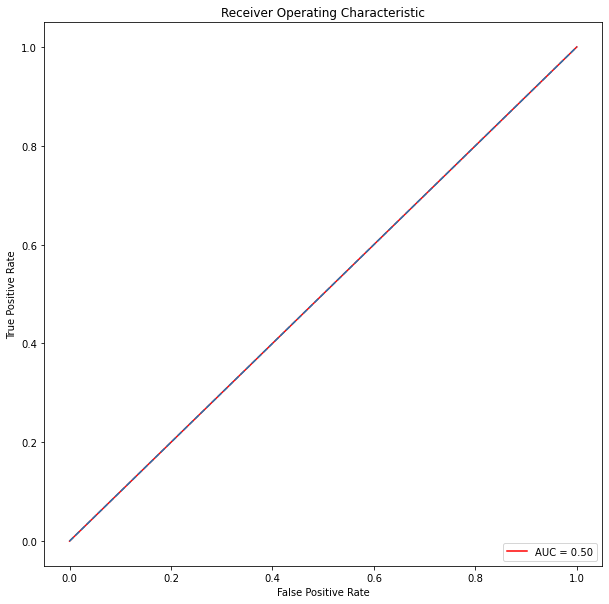

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_dumies,true_positive_rate_dumies, color='red',label = 'AUC = %0.2f' % roc_auc_dumies)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2',  max_iter=500))
#
# Create the parameter grid
#
param_grid_lr = [{
    'logisticregression__C': [0.003, 0.004, 0.005, 0.006],
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='recall',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the LogisticRegression Classifier
#
gsLR = gsLR.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsLR.best_score_)
#
# Print the model parameters of the best model
#
print(gsLR.best_params_)
#
# Print the test score of the best model
#
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

0.9103374729722853
{'logisticregression__C': 0.006}
Test accuracy: 0.918


In [14]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob = clfLR.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred = np.where(y_prob > 0.5, 1, 0) 

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc_lr = auc(false_positive_rate, true_positive_rate)
accuracy_score_lr = accuracy_score(y_test, y_pred)
recall_score_lr = recall_score(y_test, y_pred)
roc_auc_lr = auc(false_positive_rate, true_positive_rate)
print('accuracy : ', accuracy_score_lr)
print('auc : ', roc_auc_lr)
print('recall : ', recall_score_lr)

accuracy :  0.9177333333333333
auc :  0.752996333577196
recall :  0.027182866556836903


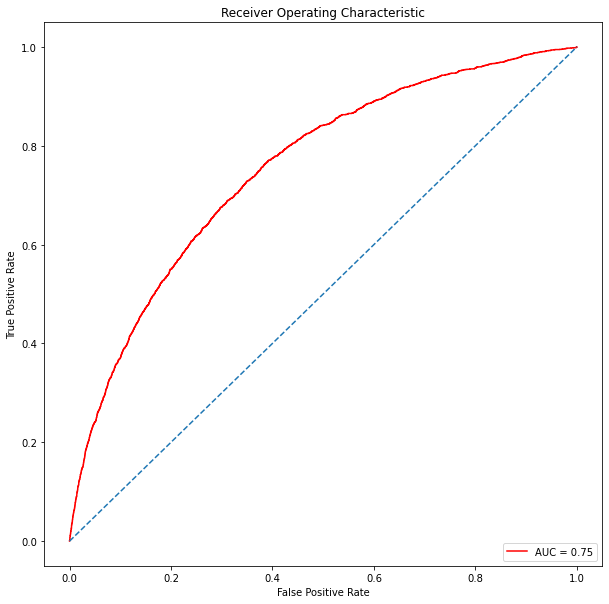

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
# Random Forest avec le dataset avec toutes ces variables
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))
#
# Create the parameter grid
#
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='recall',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC = gsRFC.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gsRFC.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

0.838605313148452
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 6}
Test accuracy: 0.835


In [18]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob_RFC = clfRFC.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred_RFC = np.where(y_prob_RFC > 0.5, 1, 0) 

false_positive_rate_RFC, true_positive_rate_RFC, thresholds = roc_curve(y_test, y_prob_RFC)
roc_auc_RFC = auc(false_positive_rate_RFC, true_positive_rate_RFC)
accuracy_score_RFC = accuracy_score(y_test, y_pred_RFC)
recall_score_RFC = recall_score(y_test, y_pred_RFC)
roc_auc_RFC = auc(false_positive_rate_RFC, true_positive_rate_RFC)
print('accuracy : ', accuracy_score_RFC)
print('auc : ', roc_auc_RFC)
print('recall : ', recall_score_RFC)

accuracy :  0.8346333333333333
auc :  0.6485586277509523
recall :  0.24217462932454695


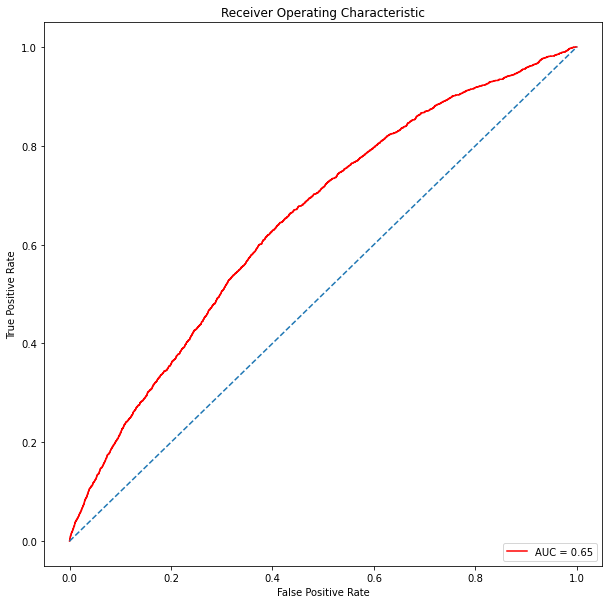

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_RFC,true_positive_rate_RFC, color='red',label = 'AUC = %0.2f' % roc_auc_RFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comparaison avec un dataset partiel qui ne contient que le fichier application_data

In [20]:
del application_data_1
fichier_initial = pd.read_csv('home_credit_partiel.csv', nrows=100000)
fichier_initial = fichier_initial.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
fichier_initial = fichier_initial.fillna(0)
fichier_initial_reduit = fichier_initial.head(100000)
fichier_initial.shape

(100000, 246)

In [21]:
# Le nombre de clients n'ayant pas remboursés leur crédit est très faible par rapport aux clients l'ayant remboursé.
print('Enregistrements avec Target à 0 : ', sum(map(lambda x: x!=1, fichier_initial_reduit['TARGET'])))
print('Enregistrements avec Target à 1 : ', sum(map(lambda x: x==1, fichier_initial_reduit['TARGET'])))
print('Nombre total d\'enregistrements : ', fichier_initial_reduit.shape[0])

Enregistrements avec Target à 0 :  91907
Enregistrements avec Target à 1 :  8093
Nombre total d'enregistrements :  100000


In [22]:
# On scinde notre fichier en 2 pour entrainer puis valider notre modèle.
from sklearn.model_selection import train_test_split

train, test = train_test_split(fichier_initial_reduit, test_size = 0.3, stratify=fichier_initial_reduit.TARGET)


In [23]:
# On rééquilibre les classes avec la bibliotheque SMOTE
from imblearn.over_sampling import SMOTE
train_target = train['TARGET']
train_sans_target = train.drop(columns=['TARGET'])
X_resampled, y_resampled = SMOTE().fit_resample(train_sans_target, train_target)

In [24]:
X_train_fi = X_resampled
y_train_fi = y_resampled
X_test_fi = test.drop(columns=['TARGET'])
y_test_fi = test['TARGET']

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipelineLR_fi = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2',  max_iter=500))
#
# Create the parameter grid
#
param_grid_lr_fi = [{
    'logisticregression__C': [0.003, 0.004, 0.005, 0.006],
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsLR_fi = GridSearchCV(estimator=pipelineLR_fi,
                     param_grid = param_grid_lr_fi,
                     scoring='recall',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the LogisticRegression Classifier
#
gsLR_fi = gsLR_fi.fit(X_train_fi, y_train_fi)
#
# Print the training score of the best model
#
print(gsLR_fi.best_score_)
#
# Print the model parameters of the best model
#
print(gsLR_fi.best_params_)
#
# Print the test score of the best model
#
clfLR_fi = gsLR_fi.best_estimator_
print('Test accuracy: %.3f' % clfLR_fi.score(X_test_fi, y_test_fi))

0.9106638785161276
{'logisticregression__C': 0.006}
Test accuracy: 0.919


In [26]:
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob_fi = clfLR_fi.predict_proba(X_test_fi)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred_fi = np.where(y_prob_fi > 0.5, 1, 0) 

false_positive_rate_fi, true_positive_rate_fi, thresholds = roc_curve(y_test_fi, y_prob_fi)
roc_auc_fi = auc(false_positive_rate_fi, true_positive_rate_fi)
accuracy_score_fi = accuracy_score(y_test_fi, y_pred_fi)
recall_score_fi = recall_score(y_test_fi, y_pred_fi)
print('accuracy : ', accuracy_score_fi)
print('auc : ', roc_auc_fi)
print('recall : ', recall_score_fi)

accuracy :  0.9190666666666667
auc :  0.713428116674486
recall :  0.005354200988467875


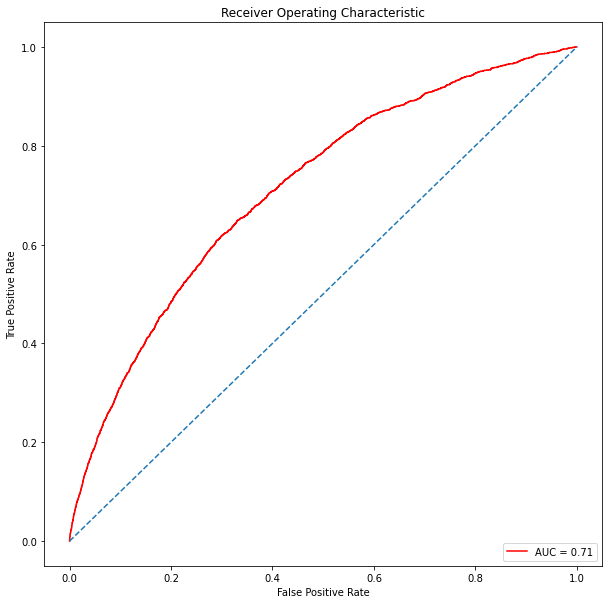

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_fi,true_positive_rate_fi, color='red',label = 'AUC = %0.2f' % roc_auc_fi)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
# Random Forest avec uniquement les variables du fichier application
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipelineRFC_fi = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))
#
# Create the parameter grid
#
param_grid_rfc_fi = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsRFC_fi = GridSearchCV(estimator=pipelineRFC_fi,
                     param_grid = param_grid_rfc_fi,
                     scoring='recall',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC_fi = gsRFC_fi.fit(X_train_fi, y_train_fi)
#
# Print the training score of the best model
#
print(gsRFC_fi.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC_fi.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC_fi.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test_fi, y_test_fi))

0.8687283803047515
{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 2}
Test accuracy: 0.848


In [29]:
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob_fi = clfRFC.predict_proba(X_test_fi)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred_fi = np.where(y_prob_fi > 0.5, 1, 0) 

false_positive_rate_fi, true_positive_rate_fi, thresholds = roc_curve(y_test_fi, y_prob_fi)
roc_auc_fi = auc(false_positive_rate_fi, true_positive_rate_fi)
accuracy_score_fi = accuracy_score(y_test_fi, y_pred_fi)
recall_score_fi = recall_score(y_test_fi, y_pred_fi)
print('accuracy : ', accuracy_score_fi)
print('auc : ', roc_auc_fi)
print('recall : ', recall_score_fi)

accuracy :  0.8481666666666666
auc :  0.6017481249033532
recall :  0.15733113673805602


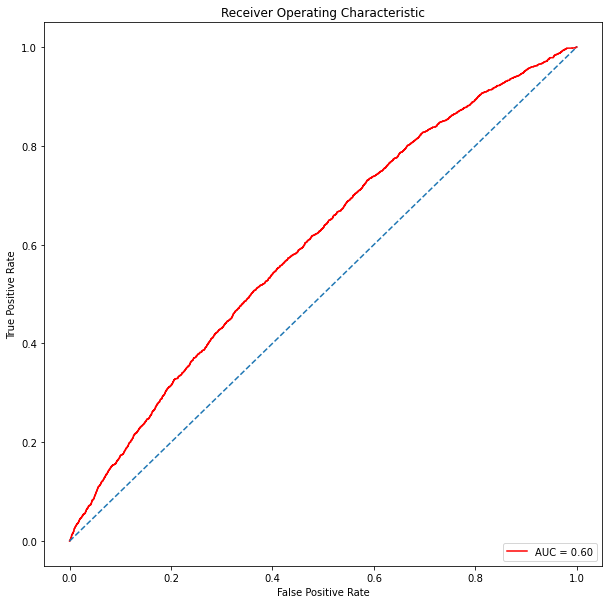

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_fi,true_positive_rate_fi, color='red',label = 'AUC = %0.2f' % roc_auc_fi)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Modèles non linéaires

In [ ]:
# SVM à noyau
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

pipeline_SVM = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# grille de paramètres
param_grid_SVM = {'svc__C': C_range, 'svc__gamma': gamma_range}

#
# Create an instance of GridSearch Cross-validation estimator
#
gs_SVM = GridSearchCV(estimator=pipeline_SVM,
                     param_grid = param_grid_SVM,
                     scoring='recall',
                     cv=5)

#Entrainement du modèle
gs_SVM = gs_SVM.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gs_SVM.best_score_)
#
# Print the model parameters of the best model
#
print(gs_SVM.best_params_)
#
# Print the test score of the best model
#
clf_SVM = gs_SVM.best_estimator_
print('Test accuracy: %.3f' % clf_SVM.score(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob = clf_SVM.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred = np.where(y_prob > 0.5, 1, 0) 

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
accuracy_score = accuracy_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
print('accuracy : ', accuracy_score)
print('auc : ', roc_auc)
print('recall : ', recall_score)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import kernel_ridge

# choisir 5 valeurs pour alpha entre 1e-2 et 1e2
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

pipeline_ridge = make_pipeline(StandardScaler(), kernel_ridge.KernelRidge(kernel='rbf')) # noyau Gaussien

# initialiser la validation croisée
gs_ridge = GridSearchCV(estimator=pipeline_ridge,
                     param_grid = param_grid_ridge,
                     scoring='accuracy',
                     cv=5)

#Entrainement du modèle
gs_ridge = gs_ridge.fit(X_train, y_train)
#
# Print the training score of the best model
#
print(gs_ridge.best_score_)
#
# Print the model parameters of the best model
#
print(gs_ridge.best_params_)
#
# Print the test score of the best model
#
clf_ridge = gs_ridge.best_estimator_
print('Test accuracy: %.3f' % clf_ridge.score(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_curve, auc
# On récupère la prédiction de la valeur positive
y_prob_ridge = clf_ridge.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred_ridge = np.where(y_prob_ridge > 0.5, 1, 0) 

false_positive_rate_ridge, true_positive_rate_ridge, thresholds = roc_curve(y_test, y_prob_ridge)
roc_auc_ridge = auc(false_positive_rate_ridge, true_positive_rate_ridge)
accuracy_score = accuracy_score(y_test, y_pred_ridge)
recall_score = recall_score(y_test, y_pred_ridge)
print('accuracy : ', accuracy_score)
print('auc : ', roc_auc)
print('recall : ', recall_score)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_ridge,true_positive_rate_ridge, color='red',label = 'AUC = %0.2f' % roc_auc_ridge)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Essayer de transformer les variables 64 bits en 32 ...!<br/>
Faire un comparatif avec les variables calculées vs sans ces variables calculées
Cout métiers + cours modèles non linéaire.

Cout métier :
Une prédiction positive signifie que le prêt ne sera pas remboursé.<br>
Une prédiction négative signifie que le prête sera remboursé.<br>
Un faux négatif est un prêt prédit remboursé alors qu'il ne le sera pas. On doit diminuer les faux négatif donc maximiser le recall.